## This notebook demonstrates how to setup and use the Rainy season Onset Metrics Package (ROMP)  

<br>




### ROMP structure and workflow

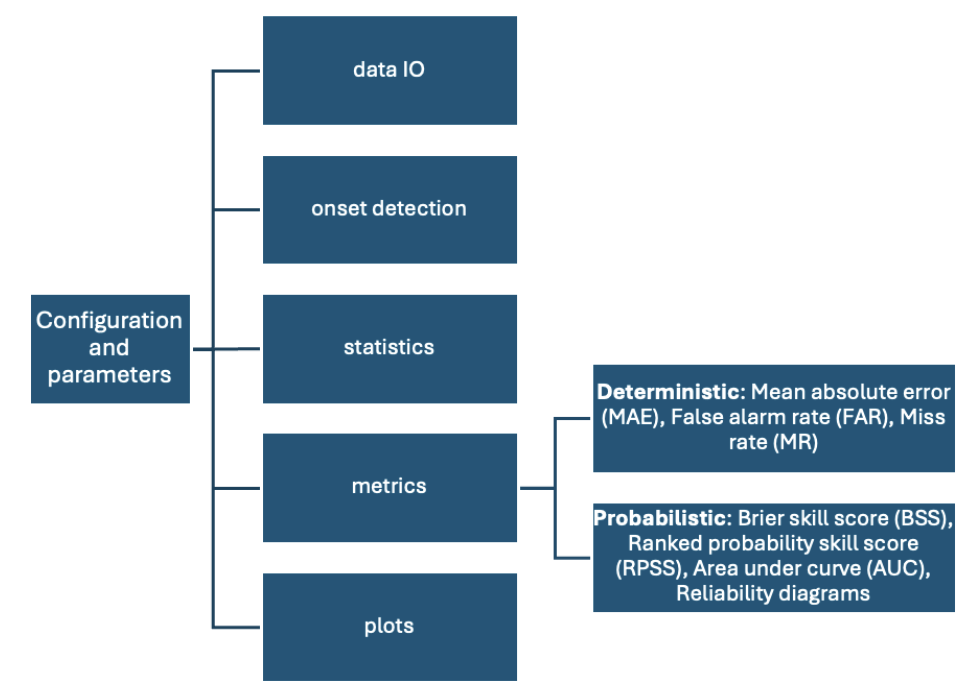





In [1]:
# import necessary libraries for this demo
from momp.lib.loader import get_cfg
from momp.utils.printing import print_cfg, print_data_info
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display

package base dir /Users/bodong/Code/benchmarking/momp



<br>


## Installation

Follow the instructions in installation guidance [document](https://docs.google.com/document/d/18iatY4sVqlNrUAXQCd-EURKtPfw-ZjNib4RkS-j3-v4/edit?tab=t.homv0v9n1oxi#heading=h.7icx9r87yopj) or [README.md](https://github.com/bosup/MOMP/blob/main/README.md) to install ROMP  

The package is installed at



In [2]:
# get the local directory where the package is installed
cfg = get_cfg()
base_dir = cfg.base_dir
print("package base dir = ", base_dir)

package base dir =  /Users/bodong/Code/benchmarking/momp


## Data preperation

With where the package base directory in mind, make sure required input data are in designated directories. It is expected that you have access to the sample data in the google cloud bucket, or have downloaded the data to your local disk.


In [3]:
# retrieve input data directories from package configuration 
print_cfg(cfg, ["obs_dir", "ref_model_dir", "model_dir_list"])

obs_dir: /Users/bodong/Code/dev_tmp/4x4/obs
ref_model_dir: /Users/bodong/Code/dev_tmp/4x4/obs
model_dir_list: ('/Users/bodong/Code/dev_tmp/4x4/aifs', '/Users/bodong/Code/dev_tmp/4x4/aifs')



    
required data include  
- **forecast model**  
- **reference model**  
- **observation (ground truth)**

and their filenames should follow certain naming convention as specified in 
- *_file_pattern

such as


In [27]:
# input data naming convention
print_cfg(cfg, "file_pattern")

obs_file_pattern: ('{}.nc', 'data_{}.nc')
ref_model_file_pattern: ('{}.nc', 'data_{}.nc')
file_pattern_list: ('{}.nc', '{}.nc')


where the placeholder is to be replaced by year or date string  

for example, 

In [4]:
# model forecast data
model_dir = Path(cfg.model_dir_list[0])
model_name = cfg.model_list[0]
print("model = ", model_name)
!ls {model_dir}

model =  AIFS
2013.nc 2014.nc 2015.nc 2019.nc 2020.nc


Acceptable data type can be either .nc or .zarr  
They must have standard spatiotemporal dimensions including time, lat, lon, and forecast initialization time, and forecast steps/days. Ensemble forecast data are expected to have an additional ensemble/member/number dimension.

For example:

In [18]:
print_data_info(model_dir)


File: 2015.nc

Dimensions:
  day: 46
  time: 35
  lat: 8
  lon: 9

Variables:
  tp


## Set package configuration & benchmarking parameters

All parameters are set in "params/config.in"

In [5]:
# full package configurations & benchmarking parameters
config_path = cfg.base_dir.joinpath("params", "config.in")
text = Path(config_path).read_text()
print(text)

# ==============================================================================
# Monsoon Onset Metrics Package (MOMP) Configuration
# Version: 0.0.1
# Description: Workflow configuration for evaluating monsoon onset forecast 
# ==============================================================================

# ------------------------------------------------------------------------------
# 1. CORE STRUCTURE & DIMENSIONS
# ------------------------------------------------------------------------------
project_name = "test MOMP run with sample data"

# Internal data layout (e.g., dimensions in the processed case).
# Frozen with major MOMP version
layout = ("model", "verification_window")

# List of models to process (e.g., "AIFS", "IFS", "NGCM").
# Must be models from the same category, e.g., all probabilistic models
# for all parameter lists in config.in, keep the trailing comma if only one item
model_list = ("AIFS", "XXXX")
#model_list = ("IFS", "NGCM")

# ------------------------------

<br>

## Run benchmarking package  

#### ROMP supports two operational modes:
- **Production mode**: Executed via the CLI for standard workflows and automated pipelines.
- **Research mode**: Accessible as an importable Python module, enabling interactive experimentation, analysis, and integration within Python scripts or Jupyter notebooks.  


1. ### Run ROMP in **production mode**  
With properly configured `config.in`, the main benchmarking workflow is executed via CLI:               

`momp-run`

Typical steps performed:
1. Load configuration
2. Set up benchmarking cases
3. Read model and observation data
4. Detect monsoon onset
5. Evaluate model against reference data
6. Generate benchmarking metrics
7. Save NetCDF outputs and figures
8. Make metric plots
with all parameters and flags properly configured, ROMP can be run via CLI as

In [29]:
! momp-run

package base dir /Users/bodong/Code/benchmarking/momp

  __  __   ___   __  __   ____
 |  \/  | / _ \ |  \/  | |  _ \\
 | |\/| || | | || |\/| | | |_) |
 | |  | || |_| || |  | | |  __/
 |_|  |_| \___/ |_|  |_| |_|

 Monsoon Onset Metrics Package (MOMP)
 Version : 0.0.1

--------------------------------------------------------------------------------
 Project    : test MOMP run with sample data
 Start Time : 2026-01-22T07:07:23
--------------------------------------------------------------------------------

 Initializing analysis pipeline...

2026-01-22 07:07:23 [INFO] Starting MOMP Workflow...
processing model onset evaluation for AIFS_1-15

Processing year 2013
Loading observation rainfall from: /Users/bodong/Code/dev_tmp/4x4/obs/2013.nc
Using 06-02 as start date for onset detection
init_time NOT in coords --> 
Processing 26 init times x 7 lats x 5 lons...

Processing Summary:
Total potential initializations: 910
Skipped (no observed onset): 390
Skipped (initialized after observed ons

<br>
<br>

Users can optionally keep an edited copy of the configuration file outside the sitepackage with user defiend  filename such as `config_job1.in`, then run ROMP as

```
momp-run -p /path_to/config_job1.in
```

2. ### Run ROMP in **Research mode**  
#### Option 1. Invoke the package API as a module  

`$python -m momp.app.onset_time_series`  

<br>

#### Option2. import ROMP as a python package  

`from momp.app.onset_time_series import obs_onset_analysis as ons`  

and then write your own diagnositic code leveraging the `ons` capabilities

<br>



### Metric Results

`dir_out` tells where the package output data are located  
spatial metrics are saved in .nc files  
domain averaged metrics are saved in .csv files

In [6]:
# benchmarking output data
dir_out = Path(cfg.dir_out)
print("\n\nbenchmarking metrics data in --> ", dir_out, "\n\n")
!ls {dir_out}



benchmarking metrics data in -->  /Users/bodong/Code/benchmarking/momp/output 


binned_skill_scores_IFS_15day.csv    spatial_metrics_AIFS_11-20.nc
binned_skill_scores_IFS_30day.csv    spatial_metrics_AIFS_16-20.nc
binned_skill_scores_NGCM_15day.csv   spatial_metrics_AIFS_16-30.nc
binned_skill_scores_NGCM_30day.csv   spatial_metrics_climatology_1-10.nc
climatology_onset_doy_2013-2015.nc   spatial_metrics_climatology_1-15.nc
climatology_onset_doy_2013-2020.nc   spatial_metrics_climatology_11-20.nc
det                                  spatial_metrics_climatology_16-20.nc
overall_skill_scores_IFS_15day.csv   spatial_metrics_climatology_16-30.nc
overall_skill_scores_IFS_30day.csv   spatial_metrics_IFS_1-15.nc
overall_skill_scores_NGCM_15day.csv  spatial_metrics_NGCM_1-15.nc
overall_skill_scores_NGCM_30day.csv  spatial_metrics_XXXX_1-10.nc
prob                                 spatial_metrics_XXXX_1-15.nc
results.pkl                          spatial_metrics_XXXX_11-20.nc
spatial_metrics_A_

<br>

Below is an example of saved binned skill scores from a probabilistic forecast  


In [7]:
window =  cfg.verification_window_list[0]
# filename = base_dir.joinpath(dir_out, f"binned_skill_scores_{model_name}_{window}day.csv")
filename = base_dir.joinpath(dir_out, f"binned_skill_scores_IFS_{window[1]}day.csv")
print("\n\n loading saved metrics from ", filename)
df_bins = pd.read_csv(filename)
df_bins



 loading saved metrics from  /Users/bodong/Code/benchmarking/momp/output/binned_skill_scores_IFS_15day.csv


,Bin,clean_bins,Fair_Brier_Skill_Score,AUC,AUC_ref,Fair_Brier_Score_Forecast,Fair_Brier_Score_Climatology
0,Days 1-5,1-5,-0.961538,0.965879,0.959318,0.058621,0.029885
1,Days 6-10,6-10,-1.469231,0.827949,0.947179,0.073793,0.029885
2,Days 11-15,11-15,-1.742857,0.825827,0.935202,0.088276,0.032184


<br>

metric plots are saved in the output figure folder as defined in `dir_fig`  



In [8]:
# metrics plots
dir_fig = Path(cfg.dir_fig)
print("\n\n metrics plots in --> ", dir_fig, "\n\n")
!ls {dir_fig}



 metrics plots in -->  /Users/bodong/Code/benchmarking/momp/figure 


climatology_onset_2013-2015.png       spatial_metrics_AIFS_16-20.png
onset_time_series.png                 spatial_metrics_AIFS_16-30.png
panel_bar_BSS_RPSS_AUC.png            spatial_metrics_climatology_1-15.png
panel_portrait_BSS_AUC.png            spatial_metrics_climatology_16-20.png
panel_portrait_mae_far_mr.png         spatial_metrics_climatology_16-30.png
reliability_IFS_15day.png             spatial_metrics_IFS_1-15.png
reliability_NGCM_15day.png            spatial_metrics_NGCM_1-15.png
skill_scores_heatmap_IFS_15day.png    spatial_metrics_XXXX_1-15.png
skill_scores_heatmap_NGCM_15day.png   spatial_metrics_XXXX_16-20.png
spatial_metrics_A_1-15.png            spatial_metrics_XXXX_16-30.png
spatial_metrics_AIFS_1-15.png


<br>

if the `plot_bar_bss_rpss_auc` flat is set to `True`, it generates a bar plot for metrics BSS, RPSS and AUC 

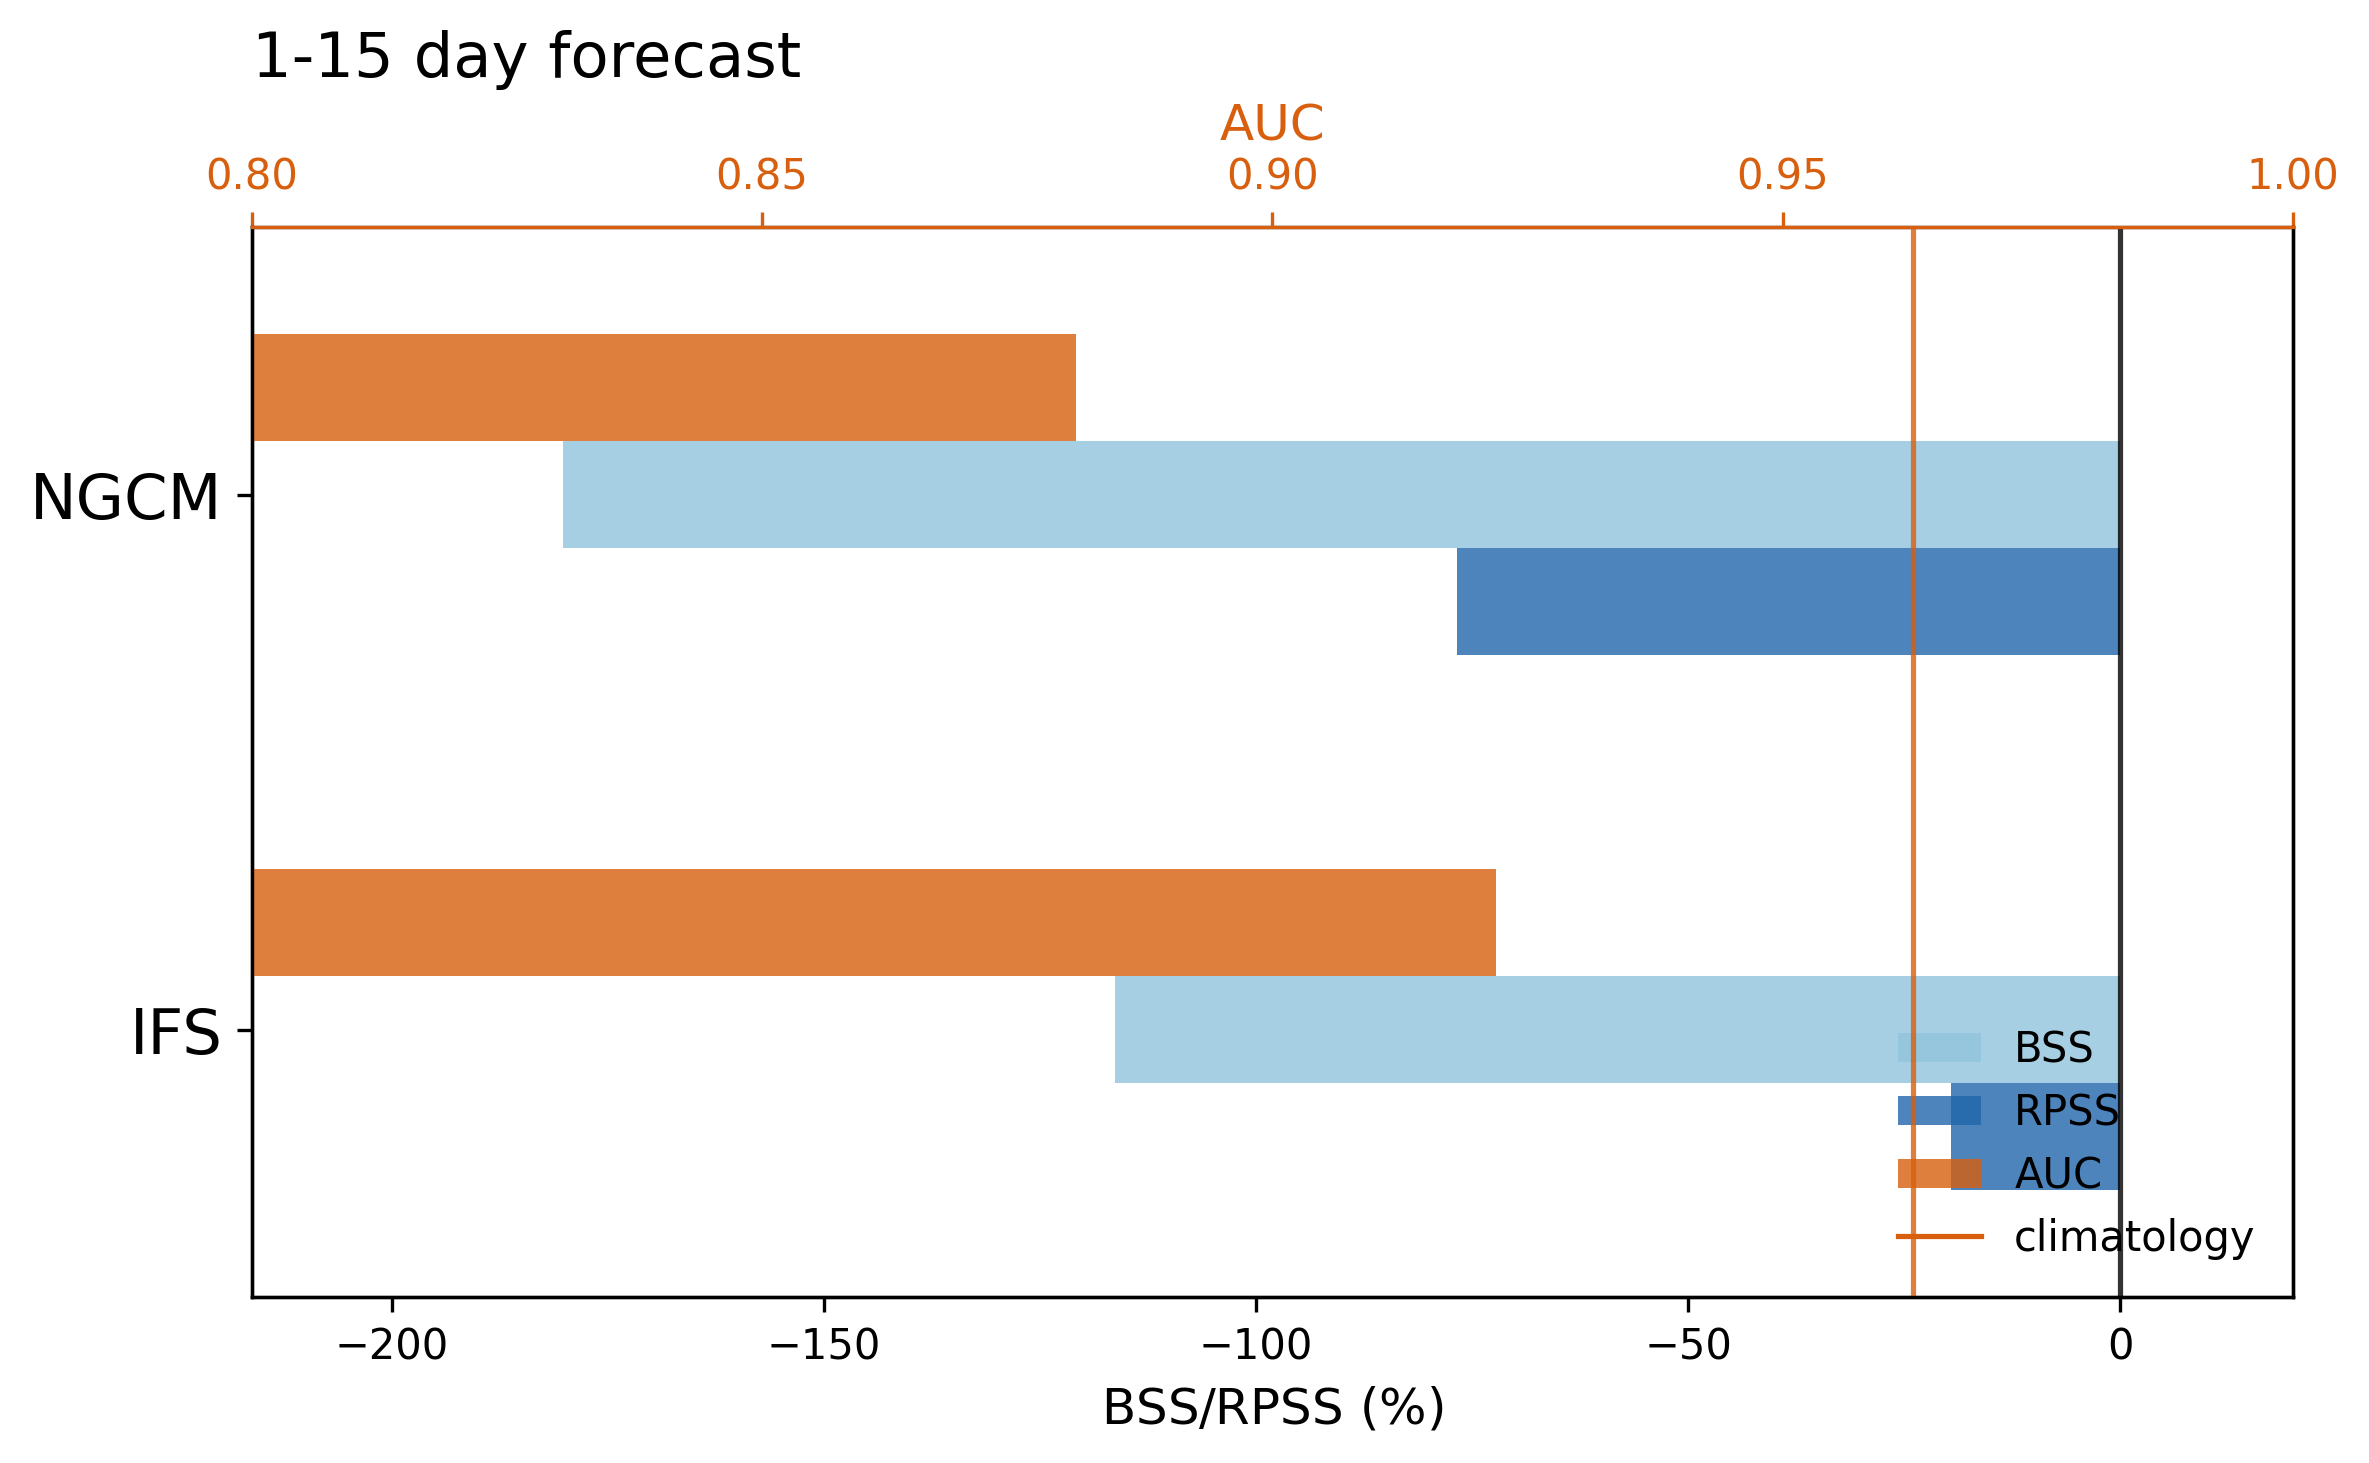

In [88]:
# Load image from file
fig_filename = base_dir.joinpath(dir_out, 'panel_bar_BSS_RPSS_AUC.png')
# img = mpimg.imread(fig_filename)  
# plt.figure(figsize=(4, 3))
# plt.imshow(img)
display(Image(filename=fig_filename, width=450))

<br>

if the `plot_reliability` flat is set to `True`, it generates a reliability diagram 

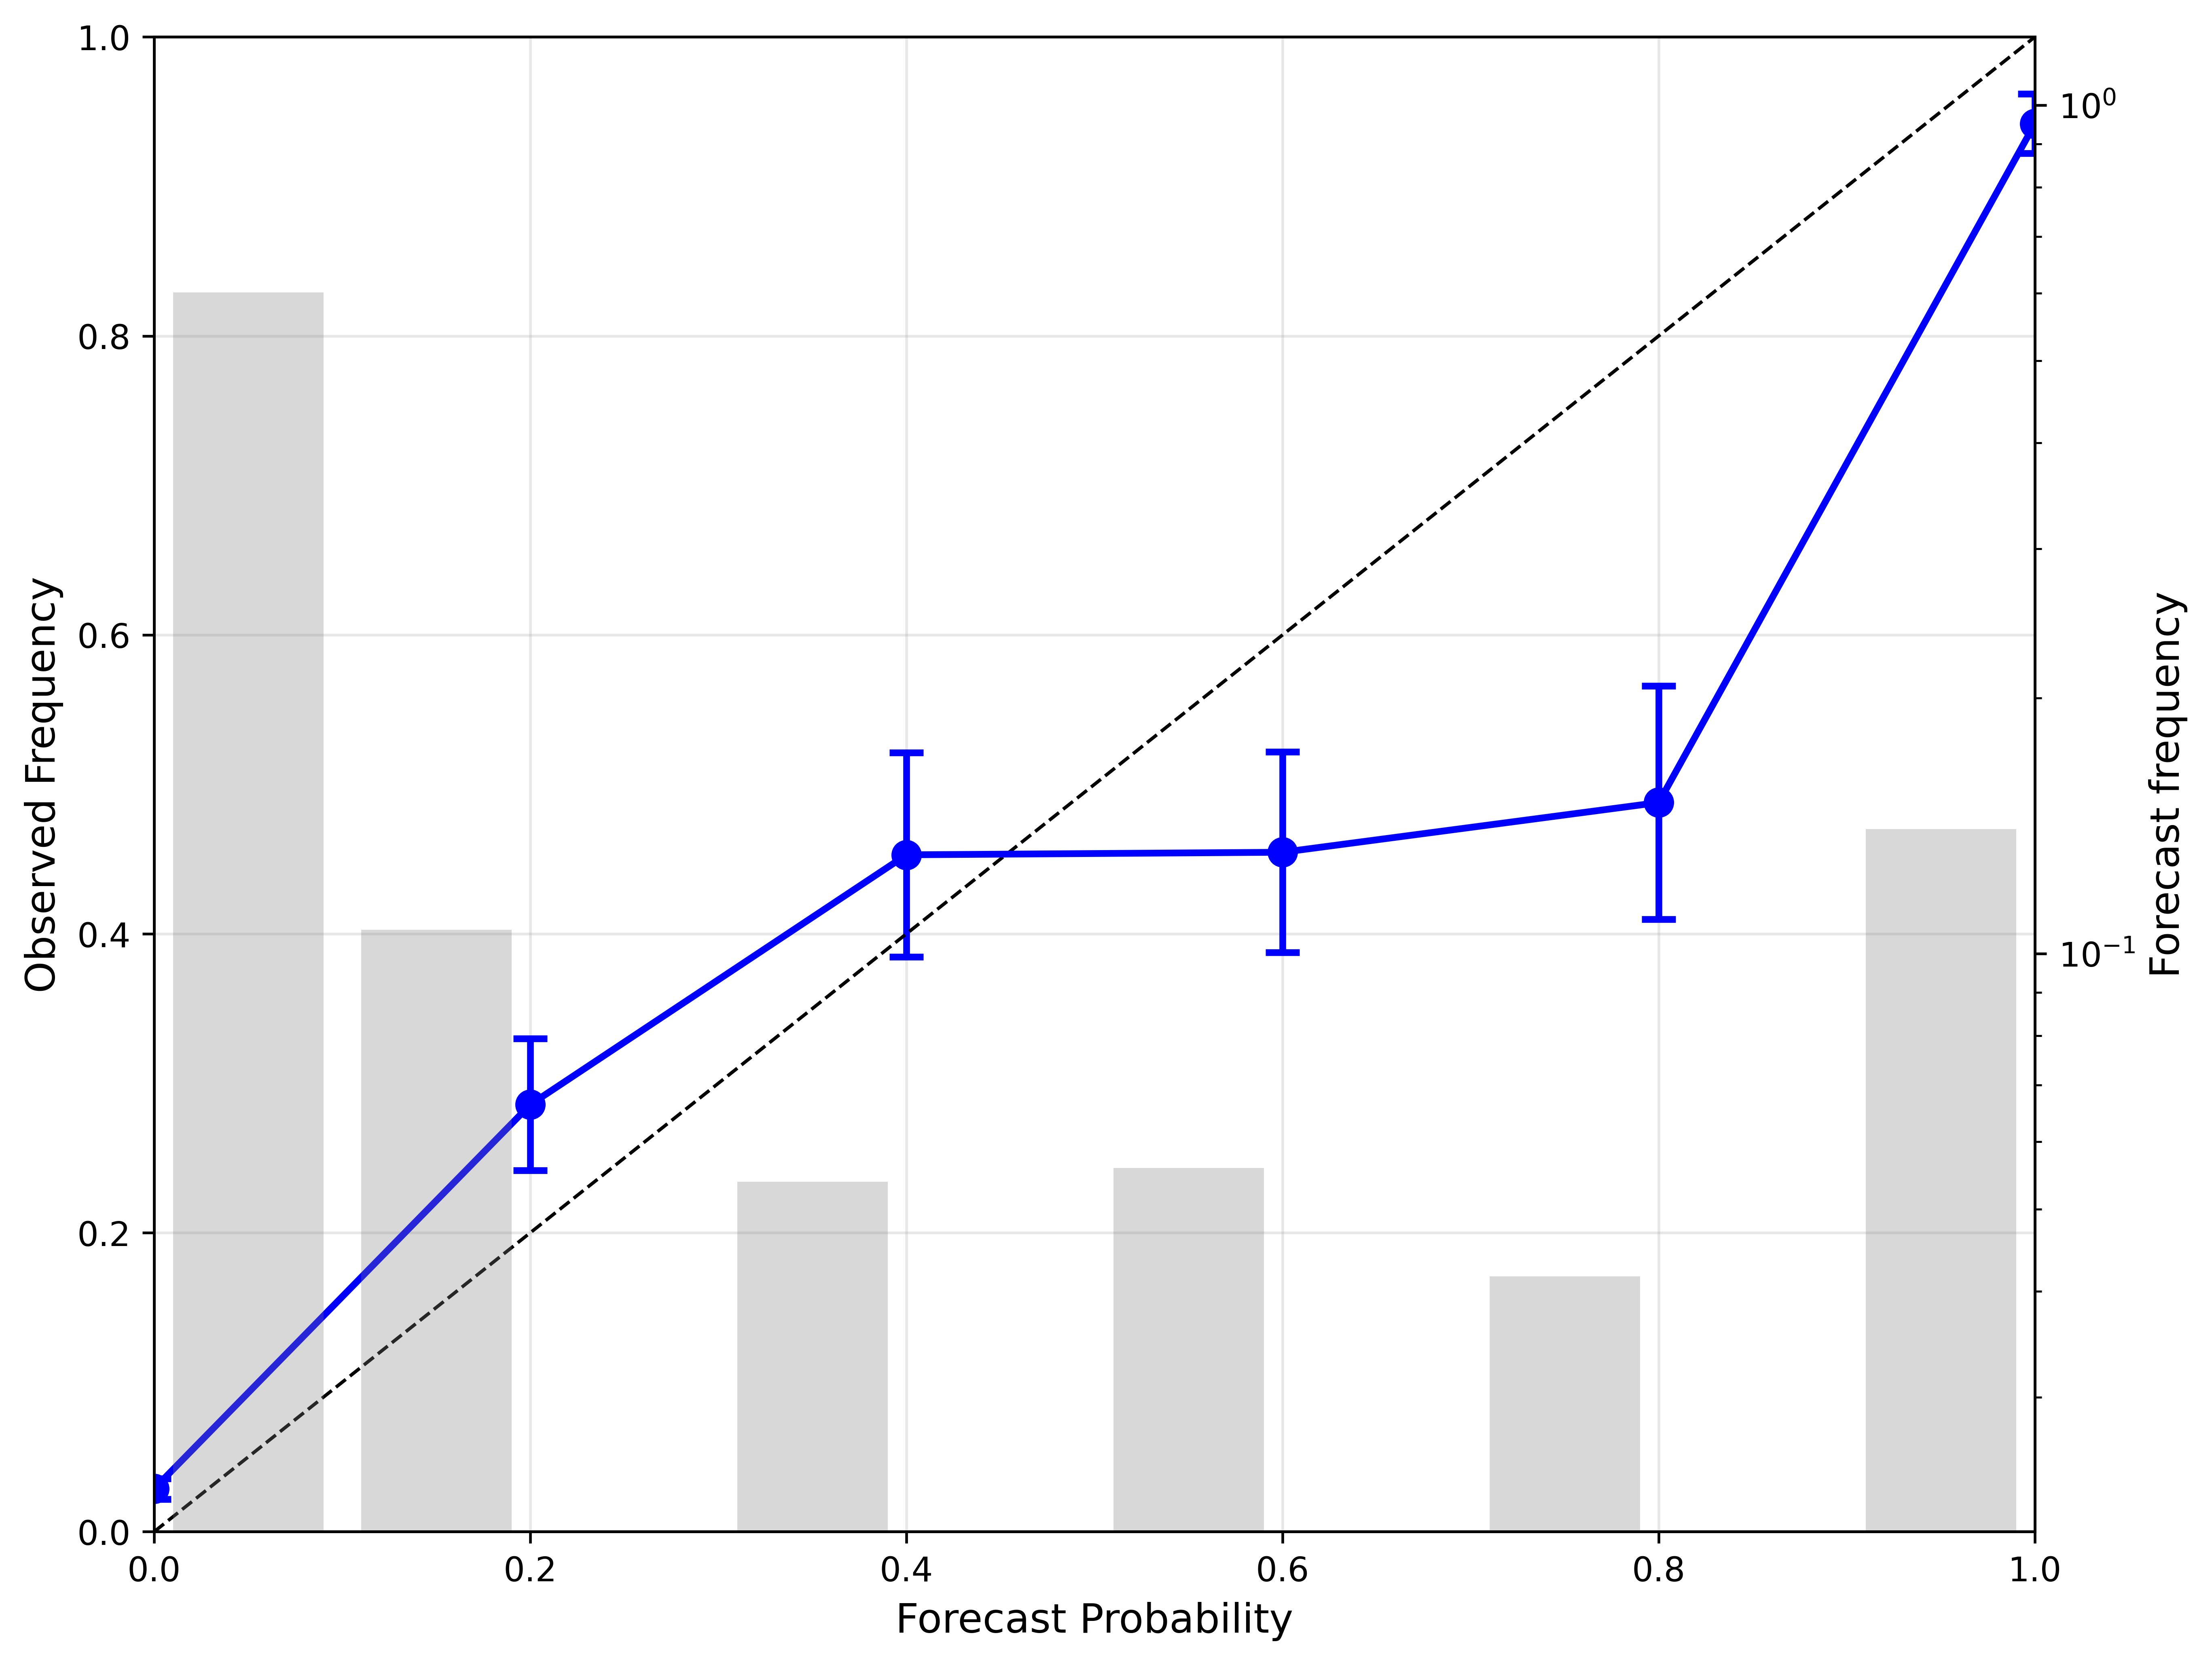

In [92]:
fig_filename = base_dir.joinpath(dir_out, f'reliability_IFS_{window[1]}day.png')
# img = mpimg.imread(fig_filename)  
# plt.figure(figsize=(4, 3))
# plt.imshow(img)
display(Image(filename=fig_filename, width=350))

<br>

if `plot_panel_heatmap_skill` set to `True`, it generates a heatmap of skill scores across models and forecast bins  


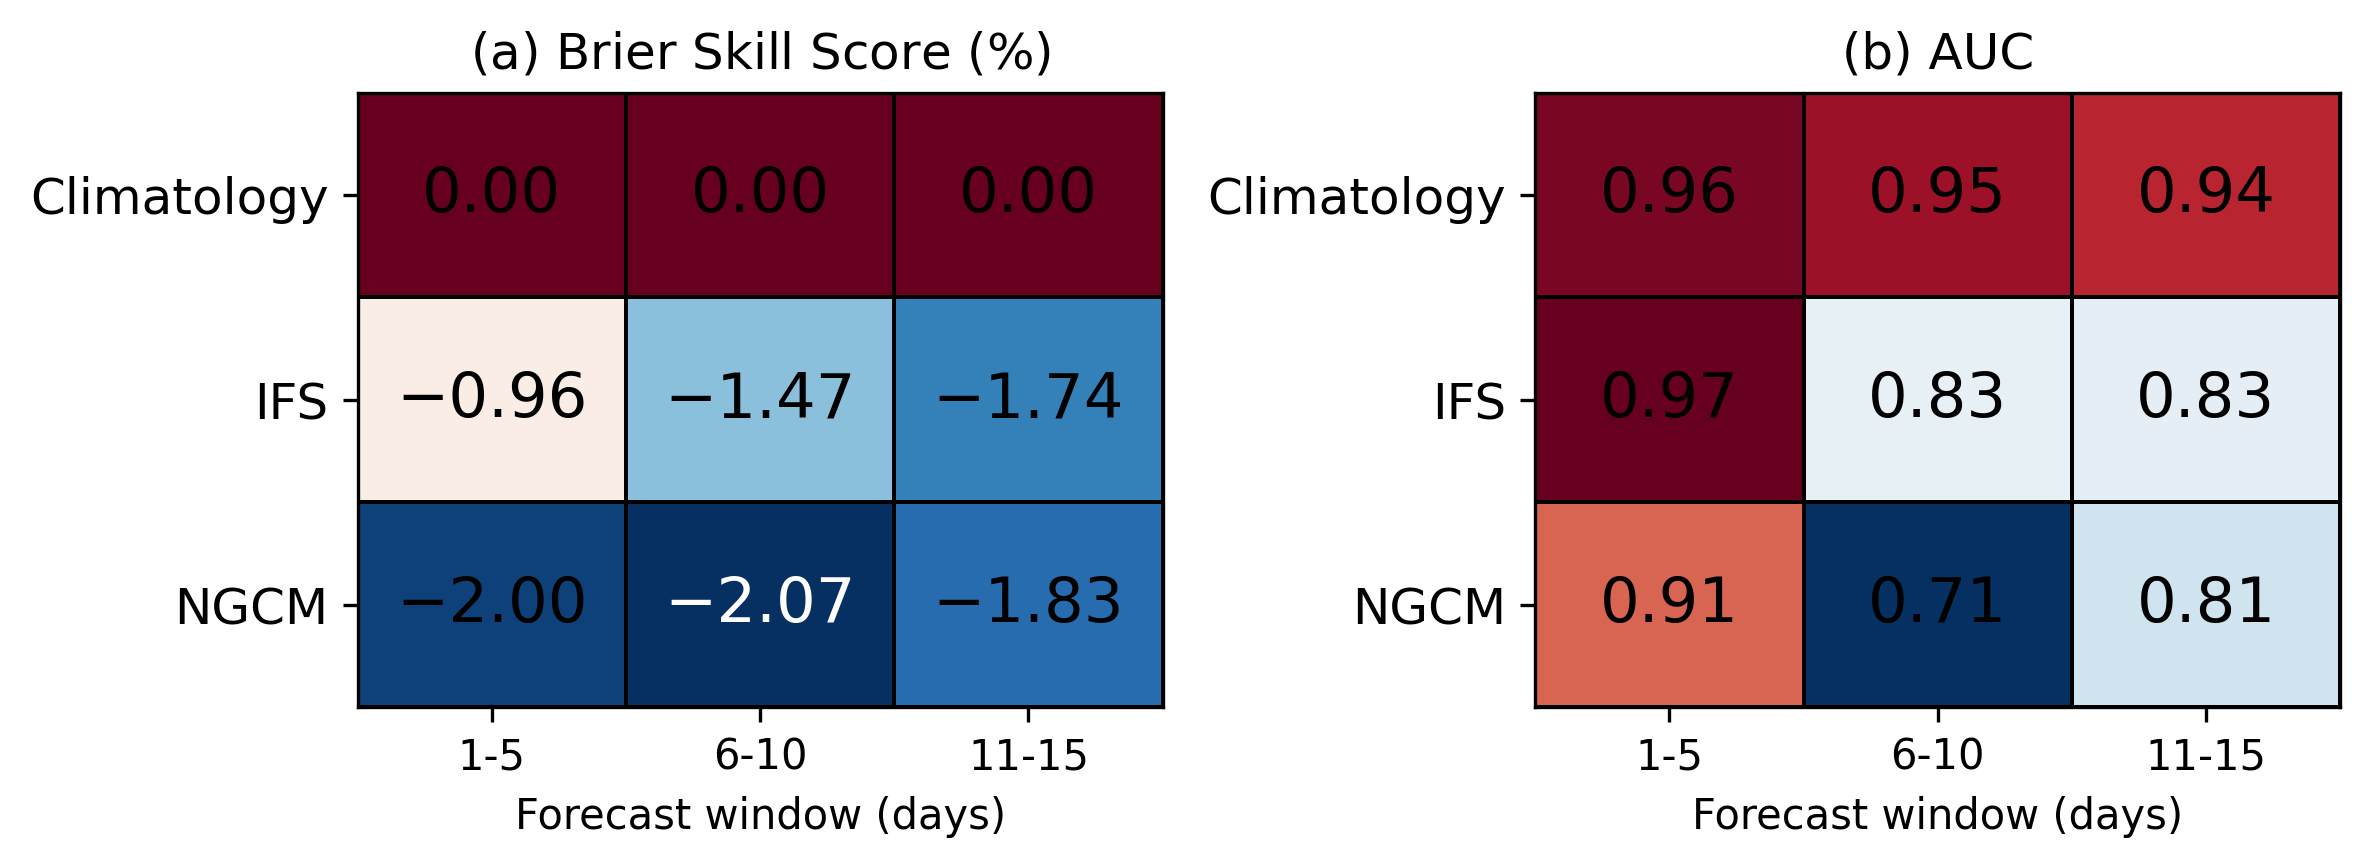

In [91]:
fig_filename = base_dir.joinpath(dir_out, 'panel_portrait_BSS_AUC.png')
display(Image(filename=fig_filename, width=450))

<br>
<br>

For deterministic forecast, spatial metrics MAE, FAR, MR are saved in netcdf files

In [67]:
filename = base_dir.joinpath(dir_out, f"spatial_metrics_{model_name}_{"-".join(map(str, window))}.nc")
ds = xr.open_dataset(filename)
print("\n\n loading saved metrics from ", filename)
ds



 loading saved metrics from  /Users/bodong/Code/benchmarking/momp/output/spatial_metrics_AIFS_1-15.nc


<xarray.Dataset> Size: 2kB
Dimensions:           (lat: 7, lon: 5)
Coordinates:
  * lat               (lat) float64 56B 8.0 12.0 16.0 20.0 24.0 28.0 32.0
  * lon               (lon) float64 40B 72.0 76.0 80.0 84.0 88.0
Data variables:
    false_alarm_rate  (lat, lon) float64 280B ...
    miss_rate         (lat, lon) float64 280B ...
    mean_mae          (lat, lon) float64 280B ...
    mae_2013          (lat, lon) float64 280B ...
    mae_2014          (lat, lon) float64 280B ...
    mae_2015          (lat, lon) float64 280B ...
Attributes:
    model:                AIFS
    years:                2013,2014,2015
    tolerance_days:       3
    verification_window:  1,15
    max_forecast_day:     15
    mok:                  6,2
    title:                Monsoon Onset MAE, FAR, MR Analysis
    description:          Spatial maps of Mean Absolute Error, False Alarm Ra...

<br>

an example of spatial error metrics plot

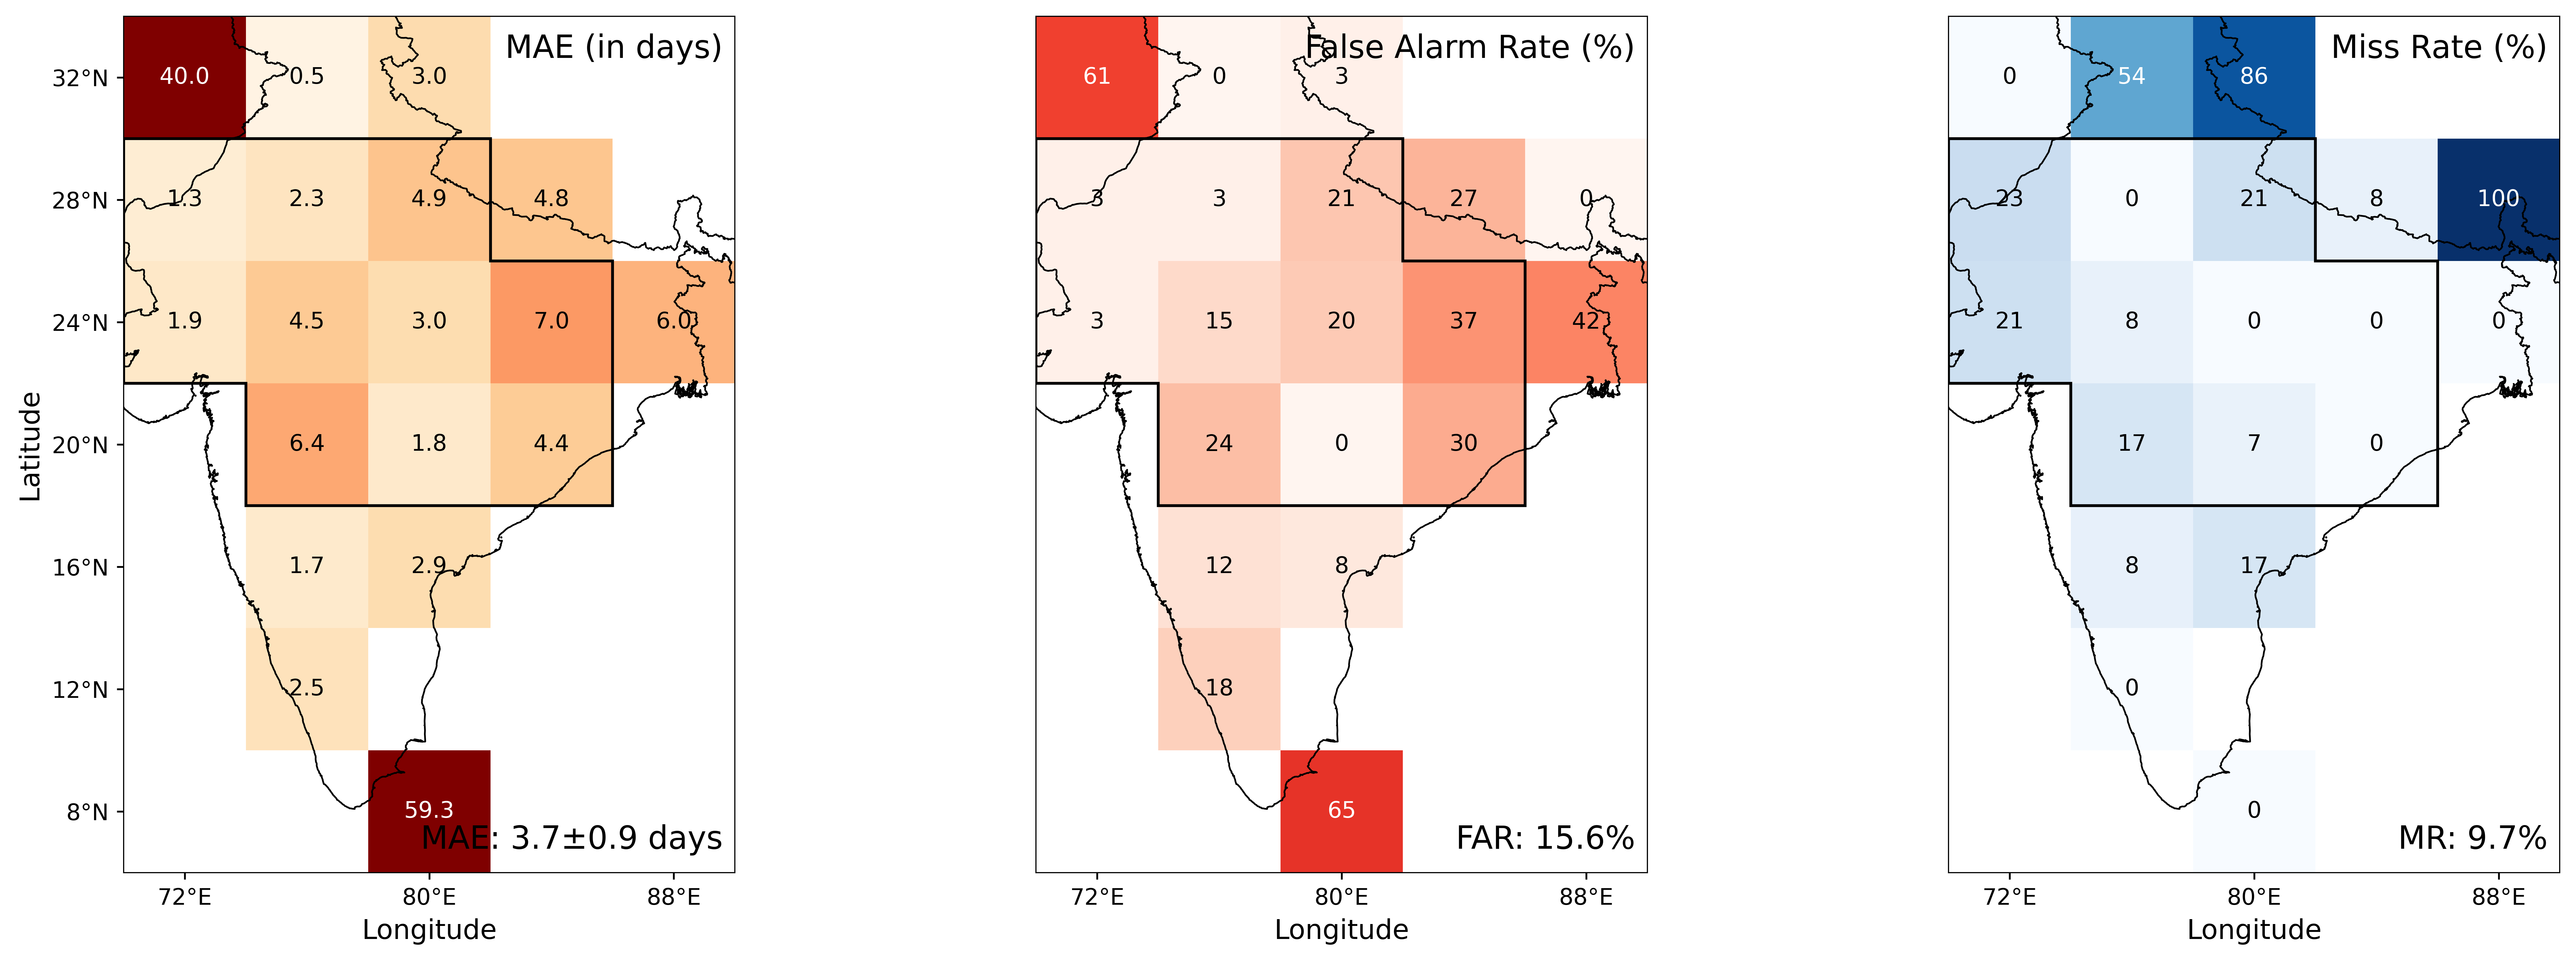

In [90]:
fig_filename = base_dir.joinpath(dir_out, f'spatial_metrics_{model_name}_{"-".join(map(str, window))}.png')
# img = mpimg.imread(fig_filename)  
# plt.figure(figsize=(8, 5))
# plt.imshow(img)
display(Image(filename=fig_filename, width=800))